In [41]:
from pgmpy.models import DynamicBayesianNetwork as DBN
dbn = DBN()

In [42]:
#edges can be added as an edge list

dbn.add_edges_from([(('D', 0), ('G', 0)), (('I', 0), ('G', 0)),
                    (('G', 0), ('L', 0)), (('D', 0), ('D', 1)),
                    (('I', 0), ('I', 1)), (('G', 0), ('G', 1)),
                    (('G', 0), ('L', 1)), (('L', 0), ('L', 1))])

In [43]:
from pgmpy import config  
from pgmpy.estimators import MaximumLikelihoodEstimator, ParameterEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from pgmpy.base import DAG

if not isinstance(dbn, (DAG, BayesianNetwork)):
    print("EM won't work")
else:
    print("EM can work for parameter learning")


EM can work for parameter learning


However, my data is fully observed at each timestep so I can use MLE.

✅ Summary & Clear Recommendation (exactly what you should do):
Define your DBN structure exactly for two timesteps only.
Let the DBN naturally scale it to match varying-length sequences.
No explicit changes are required per sequence length.
Your intuition is spot-on—the DBN handles varying lengths naturally with just a two-slice definition!

Static (time-invariant) variables, such as demographics (Age, Gender), do NOT need temporal transitions. They remain fixed across all timesteps.

However, when defining your DBN structure explicitly (for example, in pgmpy):

You still define static variables at two timesteps (0 and 1).
But you do NOT add temporal edges (edges connecting the static variable from time 0 to time 1).
Instead, static variables at each timestep (0 and 1) connect independently to their corresponding latent states at each timestep.

In [44]:
dbn = DBN()

# create edges
# Static variables influence latent state at each timestep separately (no temporal edges for static vars)
static_vars = ['age', 'gender']

# Edges from static variables to HiddenState at time 0
for var in static_vars:
    dbn.add_edge((var, 0), ('chagas', 0))

# Edges from static variables to HiddenState at time 1
for var in static_vars:
    dbn.add_edge((var, 1), ('chagas', 1))

# Latent state temporal edges (usual)
dbn.add_edge(('chagas', 0), ('chagas', 1))

ecg_vars = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Emission edges to observed sensors (at both timesteps)
for sensor in ecg_vars:
    dbn.add_edges_from([
        (('chagas', 0), (sensor, 0)),
        (('chagas', 1), (sensor, 1))
    ])

In [45]:
dbn.nodes()

NodeView((<DynamicNode(age, 0) at 0x1fb2a4c1460>, <DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(age, 1) at 0x1fb2c54bdd0>, <DynamicNode(chagas, 1) at 0x1fb2c54a8a0>, <DynamicNode(gender, 0) at 0x1fb2c54b5c0>, <DynamicNode(gender, 1) at 0x1fb2c54b860>, <DynamicNode(I, 0) at 0x1fb2c493e30>, <DynamicNode(I, 1) at 0x1fb2c4930e0>, <DynamicNode(II, 0) at 0x1fb2c493890>, <DynamicNode(II, 1) at 0x1fb2c492ea0>, <DynamicNode(III, 0) at 0x1fb2c493860>, <DynamicNode(III, 1) at 0x1fb2c4904a0>, <DynamicNode(AVR, 0) at 0x1fb2c491d60>, <DynamicNode(AVR, 1) at 0x1fb2c493530>, <DynamicNode(AVL, 0) at 0x1fb2c492990>, <DynamicNode(AVL, 1) at 0x1fb2c43f230>, <DynamicNode(AVF, 0) at 0x1fb2c43da90>, <DynamicNode(AVF, 1) at 0x1fb2c43df70>, <DynamicNode(V1, 0) at 0x1fb2c43d280>, <DynamicNode(V1, 1) at 0x1fb2c43e390>, <DynamicNode(V2, 0) at 0x1fb2c43d460>, <DynamicNode(V2, 1) at 0x1fb2c43cef0>, <DynamicNode(V3, 0) at 0x1fb2c43e120>, <DynamicNode(V3, 1) at 0x1fb2c43c9e0>, <DynamicNode(V4, 0) at 0x1fb2c

In [46]:
dbn.edges()

OutEdgeView([(<DynamicNode(age, 0) at 0x1fb2a4c1460>, <DynamicNode(chagas, 0) at 0x1fb2c536e40>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(chagas, 1) at 0x1fb2c548bc0>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(I, 0) at 0x1fb2c493e30>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(II, 0) at 0x1fb2c493890>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(III, 0) at 0x1fb2c493860>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(AVR, 0) at 0x1fb2c491d60>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(AVL, 0) at 0x1fb2c492990>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(AVF, 0) at 0x1fb2c43da90>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(V1, 0) at 0x1fb2c43d280>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(V2, 0) at 0x1fb2c43d460>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNode(V3, 0) at 0x1fb2c43e120>), (<DynamicNode(chagas, 0) at 0x1fb2c536e40>, <DynamicNod

In [47]:
import math

original_freq = 400 # samples per second (Hz)
aggregation_interval = 1
steps_per_interval = original_freq * aggregation_interval
max_obs_length = 4096
max_intervals = max_obs_length / steps_per_interval
max_intervals = math.ceil(max_intervals)
max_intervals

11

The longest Observation is 4096, with one interval a second that is 11 intervals.

Create the training dataset - save it for good measure

In [48]:
import pandas as pd
import numpy as np

static_vars = ['age', 'gender']
dynamic_vars = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF',
                'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'chagas']


def createEmptyTrainingDF(static_vars, dynamic_vars, max_timesteps):
    columns = []
    for t in range(max_timesteps): # t = 0, 1, ..., 10
        for var in dynamic_vars + static_vars:
            columns.append((var, t))

    df_all_obs = pd.DataFrame(columns=pd.MultiIndex.from_tuples(columns))

    return df_all_obs

all_obs_df = createEmptyTrainingDF(static_vars, dynamic_vars, max_intervals)
all_obs_df.columns

MultiIndex([(     'I',  0),
            (    'II',  0),
            (   'III',  0),
            (   'AVR',  0),
            (   'AVL',  0),
            (   'AVF',  0),
            (    'V1',  0),
            (    'V2',  0),
            (    'V3',  0),
            (    'V4',  0),
            ...
            (   'AVF', 10),
            (    'V1', 10),
            (    'V2', 10),
            (    'V3', 10),
            (    'V4', 10),
            (    'V5', 10),
            (    'V6', 10),
            ('chagas', 10),
            (   'age', 10),
            ('gender', 10)],
           length=165)

In [49]:
print(all_obs_df)

Empty DataFrame
Columns: [(I, 0), (II, 0), (III, 0), (AVR, 0), (AVL, 0), (AVF, 0), (V1, 0), (V2, 0), (V3, 0), (V4, 0), (V5, 0), (V6, 0), (chagas, 0), (age, 0), (gender, 0), (I, 1), (II, 1), (III, 1), (AVR, 1), (AVL, 1), (AVF, 1), (V1, 1), (V2, 1), (V3, 1), (V4, 1), (V5, 1), (V6, 1), (chagas, 1), (age, 1), (gender, 1), (I, 2), (II, 2), (III, 2), (AVR, 2), (AVL, 2), (AVF, 2), (V1, 2), (V2, 2), (V3, 2), (V4, 2), (V5, 2), (V6, 2), (chagas, 2), (age, 2), (gender, 2), (I, 3), (II, 3), (III, 3), (AVR, 3), (AVL, 3), (AVF, 3), (V1, 3), (V2, 3), (V3, 3), (V4, 3), (V5, 3), (V6, 3), (chagas, 3), (age, 3), (gender, 3), (I, 4), (II, 4), (III, 4), (AVR, 4), (AVL, 4), (AVF, 4), (V1, 4), (V2, 4), (V3, 4), (V4, 4), (V5, 4), (V6, 4), (chagas, 4), (age, 4), (gender, 4), (I, 5), (II, 5), (III, 5), (AVR, 5), (AVL, 5), (AVF, 5), (V1, 5), (V2, 5), (V3, 5), (V4, 5), (V5, 5), (V6, 5), (chagas, 5), (age, 5), (gender, 5), (I, 6), (II, 6), (III, 6), (AVR, 6), (AVL, 6), (AVF, 6), (V1, 6), (V2, 6), (V3, 6), (V4, 6),

Now I have to come up with some function that loops through the entire dbn_dataset folder, processes each record into its own df, and flattens that record into one row and appends it to all_obs_df.

In [50]:
def temporalAggregation(record_path, aggregation_interval):
    """
    Given a record path, take the signal and temporally aggregate it averaging observations over steps of {interval_length}

    record_path (str): path to the record without the file extension at the end
    interval_length (int): length of the interval of aggregation in seconds?

    return: aggregatedSignal (str) a 2d array of size (original_length / 400, 12)
    """

    # take the record path and read the record
    record = wfdb.rdrecord(record_path)

    original_freq = 400 # samples per second (Hz)
    steps_per_interval = original_freq * aggregation_interval

    # extract p_signal into a dataframe
    df = pd.DataFrame(record.p_signal)

    # Set the column names as the lead names (from the 'sig_name' attribute)
    df.columns = record.sig_name

    num_intervals = int(np.ceil(df.shape[0] / steps_per_interval))
    aggregated_rows = []

    for i in range(num_intervals):
        start = i * steps_per_interval
        end = min((i+1) * steps_per_interval, df.shape[0])
        segment = df.iloc[start:end]

        aggregated_features = segment.mean().to_dict()
        aggregated_features['interval'] = i


        aggregated_rows.append(aggregated_features)

    agg_df = pd.DataFrame(aggregated_rows)

    return agg_df 

In [51]:
def addGenderAgeChagas(df, record_path):
    """
    Given a dataframe of temporally aggregated data, add gender, age, and chagas columbns
    """

    # take the record path and read the record
    record = wfdb.rdrecord(record_path)

    # 'comments': ['Age: 68', 'Sex: Female', 'Chagas label: False', 'Source: CODE-15%']
    age = int(record.comments[0].split(':')[1])
    
    if record.comments[1].split(':')[1] == ' Male':
        gender = 0
    else:
        gender = 1

    if record.comments[2].split(':')[1] == ' False':
        chagas = 0
    else:
        chagas = 1
    
    column_len = df.shape[0]

    df['age'] = [age] * column_len
    df['gender'] = [gender] * column_len
    df['chagas'] = [chagas] * column_len

    return df

In [52]:
import wfdb
from pathlib import Path

dbn_dataset_path = "/Users/evanzimm/GitHub/python-example-2025/dbn_dataset"
aggregation_interval = 1

def populateTrainingDF(path, df, aggregation_interval, static_vars, dynamic_vars, max_timesteps):
    directory = Path(path)
    latent_var = 'chagas'

    # Loop through all header files in the directory
    for file in directory.glob('*.hea'):
        file_name_without_extension = file.stem  # Get file name without extension
        
        file_path_without_extension = str(directory / file_name_without_extension)

        obs_df = temporalAggregation(file_path_without_extension, aggregation_interval)

        obs_df = addGenderAgeChagas(obs_df, file_path_without_extension)

        obs_length = len(obs_df)
        obs_data = {}

        for t in range(max_timesteps):
            if t < obs_length:
                # Explicitly assign observed ECG signals
                for var in dynamic_vars:
                    obs_data[(var, t)] = obs_df.loc[t, var]
            else:
                # Explicitly pad ECG signals with NaNs
                for var in dynamic_vars:
                    obs_data[(var, t)] = np.nan

            # Explicitly repeat latent variable and static vars at ALL timesteps
            obs_data[(latent_var, t)] = obs_df.loc[0, latent_var]
            for var in static_vars:
                obs_data[(var, t)] = obs_df.loc[0, var]
        
        # Append observation explicitly as a single row
        df_obs = pd.DataFrame([obs_data])
        df = pd.concat([df, df_obs], ignore_index=True)
    
    return df


test_flat_df = populateTrainingDF(dbn_dataset_path, all_obs_df, aggregation_interval, static_vars, dynamic_vars, max_intervals)
test_flat_df.head()

C:\Users\evanzimm\AppData\Local\Temp\ipykernel_15348\1570429175.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_obs], ignore_index=True)


,I,II,III,AVR,AVL,AVF,V1,V2,V3,V4,...,AVF,V1,V2,V3,V4,V5,V6,chagas,age,gender
,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
0,1.189717,2.989355,1.799630,-2.091557,-0.306877,2.392425,3.623652,-0.329855,0.437590,3.854805,...,0.875812,3.003750,0.375854,0.810865,2.458510,-0.121979,1.201510,0,72,0
1,-0.416905,-0.483162,-0.066250,0.451133,-0.173463,-0.272645,-0.085975,0.135205,-0.834242,-1.204358,...,-0.293521,0.346260,0.389479,-0.522823,-0.727958,-1.237385,-1.545521,0,20,0
2,-1.349428,-1.734535,-0.385063,1.543798,-0.480300,-1.057880,0.366885,0.265470,0.789120,0.908312,...,-1.396750,0.310594,0.341698,0.703531,0.960708,0.495802,0.057865,0,22,1
3,-0.009242,-0.005120,0.004133,0.012065,-0.004203,0.001892,0.061787,0.006043,0.003800,0.006427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,64,1
4,0.057657,-0.018195,-0.075875,-0.015145,0.069143,-0.044857,0.314060,0.318828,0.316877,0.199120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,47,1


In [53]:
test_flat_df.shape

(3268, 165)

Now my data is prepared, I should probably do some sort of train/test split? 80/20? Keeping class balance for good measure.

In [54]:
from sklearn.model_selection import train_test_split

class_labels = test_flat_df[('chagas', 0)]

# Perform explicit 80/20 stratified train-test split
df_train, df_test = train_test_split(
    test_flat_df,
    test_size=0.2,
    stratify=class_labels,
    random_state=42  # reproducibility
)

# Verify explicit class balance:
print("Training class distribution:")
print(df_train[('chagas', 0)].value_counts(normalize=True))

print("\nTesting class distribution:")
print(df_test[('chagas', 0)].value_counts(normalize=True))

Training class distribution:
(chagas, 0)
1    0.5
0    0.5
Name: proportion, dtype: float64

Testing class distribution:
(chagas, 0)
0    0.5
1    0.5
Name: proportion, dtype: float64


Now I think the next step would be to call the fit function to the dataset. dbn.fit(data, estimator='MLE')

It turns out that I need to discretize the continuous vars to work with DBNs in pgmpy. This may cause me to lose some information but I will try.

In [55]:
import pandas as pd
import numpy as np
continuous_vars = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF',
                'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'age']


def discretize_train(df_train, continuous_vars, n_bins=4):
    """
    Discretize continuous columns in df_train using quantile-based binning.
    Returns:
      - df_train_discretized: a copy of df_train with discretized columns
      - bin_edges_dict: a dict storing the bin edges for each (var, time_step)
    """
    df_train_discretized = df_train.copy()
    bin_edges_dict = {}

    for col in df_train.columns:
        var_name, t_step = col
        if var_name in continuous_vars:
            # Extract column series
            col_series = df_train_discretized[col]

            # Drop NaN to calculate bin edges
            non_null = col_series.dropna()
            if len(non_null) == 0:
                # If the column is all NaNs, skip
                continue

            # Get discretized labels + bin edges using quantiles
            discretized, edges = pd.qcut(non_null, q=n_bins, labels=False, 
                                         duplicates='drop', retbins=True)

            # Store bin edges
            bin_edges_dict[col] = edges

            discretized_series = pd.Series(discretized, index=non_null.index)
            discretized_series = discretized_series.astype(int)
            print(discretized_series)


            # Put discretized values back in (only for non-null indices)
            df_train_discretized.loc[non_null.index, col] = discretized_series

    return df_train_discretized, bin_edges_dict

# Example usage on your training set:
df_train_discretized, bin_edges_dict = discretize_train(df_train, continuous_vars, n_bins=4)

df_train_discretized.head()[('age',10)]


109     3
237     2
2504    3
1192    2
2809    2
       ..
1325    3
2326    3
773     0
884     2
216     3
Name: (I, 0), Length: 2614, dtype: int64
109     1
237     2
2504    3
1192    1
2809    0
       ..
1325    3
2326    3
773     0
884     1
216     0
Name: (II, 0), Length: 2614, dtype: int64
109     0
237     2
2504    0
1192    0
2809    0
       ..
1325    3
2326    0
773     3
884     0
216     0
Name: (III, 0), Length: 2614, dtype: int64
109     1
237     1
2504    0
1192    2
2809    2
       ..
1325    0
2326    0
773     3
884     1
216     3
Name: (AVR, 0), Length: 2614, dtype: int64
109     3
237     1
2504    3
1192    2
2809    2
       ..
1325    3
2326    3
773     0
884     3
216     3
Name: (AVL, 0), Length: 2614, dtype: int64
109     0
237     2
2504    3
1192    0
2809    0
       ..
1325    3
2326    0
773     3
884     1
216     0
Name: (AVF, 0), Length: 2614, dtype: int64
109     2
237     2
2504    3
1192    1
2809    2
       ..
1325    0
2326    0
773  

109     1
237     2
2504    1
1192    1
2809    0
Name: (age, 10), dtype: object

In [56]:
print(df_train_discretized.dtypes)

I       0     float64
II      0     float64
III     0     float64
AVR     0     float64
AVL     0     float64
               ...   
V5      10    float64
V6      10    float64
chagas  10     object
age     10     object
gender  10     object
Length: 165, dtype: object


In [57]:
df_train_discretized.head()

,I,II,III,AVR,AVL,AVF,V1,V2,V3,V4,...,AVF,V1,V2,V3,V4,V5,V6,chagas,age,gender
,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
109,3.0,1.0,0.0,1.0,3.0,0.0,2.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
237,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,1
2504,3.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,0.0,...,2.0,3.0,2.0,3.0,1.0,0.0,0.0,1,1,0
1192,2.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2809,2.0,0.0,0.0,2.0,2.0,0.0,2.0,3.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


You can convert all the columns to a numeric type (specifically to the pandas nullable integer type "Int64") after discretization. This way, you perform the discretization first and then, in a separate step, convert every column to integers. 

This loop will iterate over every column in your DataFrame and attempt to convert it to an integer type. Using errors='coerce' helps ensure that any non-numeric values become NaN (which is acceptable for the nullable "Int64" type) rather than causing an error.

In [58]:
for col in df_train_discretized.columns:
    # Use pd.to_numeric to force conversion; errors='coerce' will turn non-numeric entries into NaN,
    # and then .astype('Int64') will convert the column to the pandas nullable integer type.
    df_train_discretized[col] = pd.to_numeric(df_train_discretized[col], errors='coerce').astype("Int64")

# Check the dtypes
print(df_train_discretized.dtypes)

I       0     Int64
II      0     Int64
III     0     Int64
AVR     0     Int64
AVL     0     Int64
              ...  
V5      10    Int64
V6      10    Int64
chagas  10    Int64
age     10    Int64
gender  10    Int64
Length: 165, dtype: object


In [59]:
len(bin_edges_dict.keys()) # 13 * 11 = 143

143

In [60]:
df_train_discretized.shape

(2614, 165)

In [61]:
df_train.shape

(2614, 165)

In [62]:
dbn.fit(df_train_discretized) # 1.6s???

In [63]:
print(dbn.get_cpds())

[<TabularCPD representing P((chagas, 0):2 | (age, 0):4, (gender, 0):2) at 0x1fb2c27ea80>, <TabularCPD representing P((III, 0):4 | (chagas, 0):2) at 0x1fb2c3252b0>, <TabularCPD representing P((AVL, 0):4 | (chagas, 0):2) at 0x1fb2d5f71d0>, <TabularCPD representing P((V6, 0):4 | (chagas, 0):2) at 0x1fb2d6b59d0>, <TabularCPD representing P((gender, 0):2) at 0x1fb2d6b5760>, <TabularCPD representing P((AVF, 0):4 | (chagas, 0):2) at 0x1fb2d5f4170>, <TabularCPD representing P((V2, 0):4 | (chagas, 0):2) at 0x1fb2d6b5d30>, <TabularCPD representing P((V3, 0):4 | (chagas, 0):2) at 0x1fb2d6b67b0>, <TabularCPD representing P((V4, 0):4 | (chagas, 0):2) at 0x1fb2d6b7320>, <TabularCPD representing P((AVR, 0):4 | (chagas, 0):2) at 0x1fb2d5f7020>, <TabularCPD representing P((V1, 0):4 | (chagas, 0):2) at 0x1fb2d6b74d0>, <TabularCPD representing P((V5, 0):4 | (chagas, 0):2) at 0x1fb2d6b4fe0>, <TabularCPD representing P((I, 0):4 | (chagas, 0):2) at 0x1fb2c29a030>, <TabularCPD representing P((II, 0):4 | (cha

Now Test?

In [64]:
def discretize_test(df_test, bin_edges_dict):
    """
    Apply the bin edges from training to df_test.
    """
    df_test_discretized = df_test.copy()

    for col, edges in bin_edges_dict.items():
        if col not in df_test_discretized.columns:
            continue  # skip if column doesn't exist in test

        col_series = df_test_discretized[col]
        non_null = col_series.dropna()

        # Use pd.cut with the same bin edges
        discretized = pd.cut(non_null, bins=edges, labels=False, include_lowest=True)

        discretized_series = pd.Series(discretized, index=non_null.index)
        discretized_series = discretized_series.astype("Int64")

        df_test_discretized.loc[non_null.index, col] = discretized_series

    return df_test_discretized

# Example usage on your test set:
df_test_discretized = discretize_test(df_test, bin_edges_dict)


C:\Users\evanzimm\AppData\Local\Temp\ipykernel_15348\1013692316.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<IntegerArray>
[1, 3, 3, 3, 0, 1, 2, 0, 3, 3,
 ...
 2, 1, 2, 1, 2, 0, 3, 0, 1, 0]
Length: 654, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test_discretized.loc[non_null.index, col] = discretized_series
C:\Users\evanzimm\AppData\Local\Temp\ipykernel_15348\1013692316.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<IntegerArray>
[1, 1, 0, 0, 3, 1, 2, 3, 3, 3,
 ...
 3, 3, 3, 1, 1, 0, 0, 2, 2, 1]
Length: 654, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test_discretized.loc[non_null.index, col] = discretized_series
C:\Users\evanzimm\AppData\Local\Temp\ipykernel_15348\1013692316.py:2

In [65]:
print(df_test_discretized.dtypes)

I       0     Float64
II      0     float64
III     0     Float64
AVR     0     Float64
AVL     0     Float64
               ...   
V5      10    float64
V6      10    float64
chagas  10     object
age     10     object
gender  10     object
Length: 165, dtype: object


In [66]:
df_test_discretized.head()

,I,II,III,AVR,AVL,AVF,V1,V2,V3,V4,...,AVF,V1,V2,V3,V4,V5,V6,chagas,age,gender
,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
1111,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,<NA>,<NA>,NaN,<NA>,<NA>,NaN,NaN,0,3,1
1650,3.0,3.0,1.0,0.0,3.0,2.0,1.0,1.0,2.0,3.0,...,<NA>,<NA>,NaN,<NA>,<NA>,NaN,NaN,1,1,0
2320,3.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,3.0,0.0,1.0,2.0,1.0,0.0,0.0,1,2,1
2567,3.0,0.0,0.0,3.0,3.0,0.0,2.0,0.0,0.0,0.0,...,<NA>,<NA>,NaN,<NA>,<NA>,NaN,NaN,1,2,1
1998,0.0,3.0,3.0,0.0,0.0,3.0,0.0,1.0,1.0,3.0,...,3.0,2.0,2.0,2.0,3.0,1.0,1.0,1,3,0


In [67]:
df_test.head()

,I,II,III,AVR,AVL,AVF,V1,V2,V3,V4,...,AVF,V1,V2,V3,V4,V5,V6,chagas,age,gender
,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
1111,0.001408,-0.025830,-0.028880,0.018330,0.016798,-0.026345,-0.031750,0.004113,-0.031010,-0.010183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,84,1
1650,0.100630,0.054745,-0.045838,-0.072890,0.075592,0.006862,-0.081553,-0.019915,0.009510,0.043535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,46,0
2320,1.515755,1.011277,-0.504535,-1.261872,1.008257,0.252103,-2.222808,-0.744690,-0.492655,-3.044643,...,0.695875,-1.900927,-1.048729,-0.352177,-1.194917,-1.582292,-3.853594,1,62,1
2567,0.043275,-0.171510,-0.214815,0.065862,0.130760,-0.191350,0.003195,-0.319675,-0.886235,-0.685648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,66,1
1998,-0.094775,0.698028,0.792775,-0.303473,-0.445583,0.743590,-0.236160,-0.115027,-0.021800,0.638682,...,0.629833,-0.164865,-0.206937,-0.066375,0.364375,-0.751240,-0.500188,1,71,0


You can convert all the columns to a numeric type (specifically to the pandas nullable integer type "Int64") after discretization. This way, you perform the discretization first and then, in a separate step, convert every column to integers. 

This loop will iterate over every column in your DataFrame and attempt to convert it to an integer type. Using errors='coerce' helps ensure that any non-numeric values become NaN (which is acceptable for the nullable "Int64" type) rather than causing an error.

In [68]:
for col in df_test_discretized.columns:
    # Use pd.to_numeric to force conversion; errors='coerce' will turn non-numeric entries into NaN,
    # and then .astype('Int64') will convert the column to the pandas nullable integer type.
    df_test_discretized[col] = pd.to_numeric(df_test_discretized[col], errors='coerce').astype("Int64")

# Check the dtypes
print(df_train_discretized.dtypes)

I       0     Int64
II      0     Int64
III     0     Int64
AVR     0     Int64
AVL     0     Int64
              ...  
V5      10    Int64
V6      10    Int64
chagas  10    Int64
age     10    Int64
gender  10    Int64
Length: 165, dtype: object


In [69]:
df_test_discretized.shape

(654, 165)

In [70]:
import logging
from pgmpy.inference import DBNInference

# Set up logging to a file
logging.basicConfig(
    filename='inference.log',
    filemode='w',  # Overwrite file on each run; use 'a' to append
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO  # or DEBUG for more details
)
logger = logging.getLogger(__name__)

dbn_infer = DBNInference(dbn)  # your trained DBN

predictions = []
true_labels = []

for idx, row in df_test_discretized.iterrows():
    logger.info(f"Processing row index: {idx}")
    
    # Build evidence dict: all observed columns except the latent variable
    evidence = {}
    valid_timesteps = []

    # Identify valid timesteps based on non-NaN ECG data
    for col in df_test_discretized.columns:
        var_name, t_step = col  # deconstruct column tuple
        if var_name not in ['chagas', 'gender', 'age'] and pd.notna(row[col]):
            valid_timesteps.append(t_step)
    
    if not valid_timesteps:
        logger.info(f"Row {idx}: No valid timesteps found, skipping row.")
        continue  # or handle the case with no evidence
    
    max_valid_timestep = max(valid_timesteps)
    logger.info(f"Row {idx}: Max valid timestep = {max_valid_timestep}")

    # Build the evidence dict for valid timesteps
    for col in df_test_discretized.columns:
        var_name, t_step = col
        if t_step <= max_valid_timestep and var_name != 'chagas':
            evidence[(var_name, t_step)] = row[col]
    
    logger.info(f"Row {idx}: Raw evidence: {evidence}")

    # Clean up the evidence by converting all values to plain ints
    evidence_clean = {}
    for key, value in evidence.items():
        if pd.notna(value):
            try:
                evidence_clean[key] = int(value)
            except Exception as e:
                logger.error(f"Error converting evidence for {key}: {value}")
                raise e
    logger.info(f"Row {idx}: Cleaned evidence: {evidence_clean}")

    # Query the DBN for the latent variable at each valid timestep
    # predicted_states = {}
    # for t_step in range(max_valid_timestep + 1):
    #     try:
    #         logger.info(f"Row {idx}: Querying for ('chagas', {t_step})")
    #         query_result = dbn_infer.query(
    #             variables=[('chagas', t_step)],
    #             evidence=evidence_clean,
    #         )
    #         predicted_states[t_step] = query_result[('chagas', t_step)]
    #         logger.info(f"Row {idx}, timestep {t_step}: Prediction: {predicted_states[t_step]}")
    #     except Exception as e:
    #         logger.error(f"Error during query at row {idx}, timestep {t_step}")
    #         raise e

    # Instead of looping over every t_step, just query the last valid timestep:
    try:
        logger.info(f"Row {idx}: Querying for ('chagas', {max_valid_timestep})")
        query_result = dbn_infer.query(
            variables=[('chagas', max_valid_timestep)],
            evidence=evidence_clean,
        )
        logger.info(f"Row {idx}, timestep {max_valid_timestep}: Prediction: {query_result[('chagas', max_valid_timestep)]}")
    except Exception as e:
        logger.error(f"Error during query at row {idx}, timestep {max_valid_timestep}")
        raise e

    predictions.append(query_result[('chagas', max_valid_timestep)])
    
    # Store the true label; assuming the label is the same at all timesteps, use time 0
    true_label = row[('chagas', 0)]
    true_labels.append(true_label)
    logger.info(f"Row {idx}: True label: {true_label}")

logger.info("Inference complete.")




INFO:__main__:Processing row index: 1111
INFO:__main__:Row 1111: Max valid timestep = 7
INFO:__main__:Row 1111: Raw evidence: {('I', 0): 1, ('II', 0): 1, ('III', 0): 1, ('AVR', 0): 2, ('AVL', 0): 2, ('AVF', 0): 1, ('V1', 0): 1, ('V2', 0): 2, ('V3', 0): 1, ('V4', 0): 1, ('V5', 0): 0, ('V6', 0): 3, ('age', 0): 3, ('gender', 0): 1, ('I', 1): 2, ('II', 1): 0, ('III', 1): 0, ('AVR', 1): 3, ('AVL', 1): 3, ('AVF', 1): 0, ('V1', 1): 3, ('V2', 1): 3, ('V3', 1): 2, ('V4', 1): 3, ('V5', 1): 0, ('V6', 1): 1, ('age', 1): 3, ('gender', 1): 1, ('I', 2): 1, ('II', 2): 2, ('III', 2): 2, ('AVR', 2): 2, ('AVL', 2): 1, ('AVF', 2): 2, ('V1', 2): 1, ('V2', 2): 1, ('V3', 2): 1, ('V4', 2): 1, ('V5', 2): 3, ('V6', 2): 3, ('age', 2): 3, ('gender', 2): 1, ('I', 3): 1, ('II', 3): 2, ('III', 3): 2, ('AVR', 3): 1, ('AVL', 3): 1, ('AVF', 3): 2, ('V1', 3): 1, ('V2', 3): 1, ('V3', 3): 1, ('V4', 3): 1, ('V5', 3): 3, ('V6', 3): 0, ('age', 3): 3, ('gender', 3): 1, ('I', 4): 2, ('II', 4): 2, ('III', 4): 2, ('AVR', 4): 1, 

FTR, after changing inference code to only run inference on an observation up to the timestep with complete data, inference ran for 400 min.

Also FTR, inference for two observations completed successfully... win? I don't think so. The probability distriubtions for (chagas, t_step) are the same for every t_step. The model is effectively static across timesteps. No transition edge? Yes, there is one.

evidence at each timestep is effectively the same -> greater discretization?

In short, a deterministic transition CPD for a stable condition naturally yields the same posterior distribution for every timestep. This is not necessarily a problem—it's simply the DBN doing what you told it to do.

However, I will try greater discretization, because the predictions were both wrong. 4 bins -> 10 -> 7. For some reason the number of bins blows up the memory consumed because the dimensions become (# bins, #bins, ...,)

FTR, 4 bins, two obs takes 20 min. 7 bins also creates a memory error and 6 too and 5.

 Increasing the number of discrete bins increases the cardinality of each variable, which in turn enlarges the state space the inference algorithm must consider. Since operations like factor product in DBN inference have computational complexity that grows exponentially with the number of variables and their cardinalities, using more bins can lead to a huge memory requirement—hence the MemoryError you saw.

 From Yifan: Maybe another strategy for binning is to cut up the ECG readings into high/med/low based on thier clinical meanings. Also, check if edges make sense from a clinical perspective.

 FTR, just trying two examples, both predictions are wrong.

 30 min and it seems to be consistently predicting in the opposite direction (i.e. predicting Chagas = 1, when actually 0 and vice versa).

 338 min mark and no issues, but Dee brought up a good point. This code is slow af.





Ideas for speeding up inference:
- fewer discrete bins for continuous variables
- remove some of the 12 ECG channels
- only query one timestep, since all timesteps produce the same result
- parallel processing for inference, which would allow me to use multiple cores
- profile the code if needed
- alternative libraries

Querying only the final valid timestep seems like a good way to speed it up since all timesteps produce the same probability anyway. So I cut at 360 min and will try this way. Already way faster.

696 minutes for running inference on only the final valid timestep of each of the 684 observations. That is extremely slow!!! and tbh not practical to submit.

Now I think it would be good to analyze error metrics.

In [78]:
print(predictions[0].values)

[0.02303411 0.97696589]


In [83]:
print(print(predictions[1]))

+------------------+----------------------+
| ('chagas', 7)    |   phi(('chagas', 7)) |
+==================+======================+
| ('chagas', 7)(0) |               0.6933 |
+------------------+----------------------+
| ('chagas', 7)(1) |               0.3067 |
+------------------+----------------------+
None


In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score

y_true = df_test_discretized[('chagas', 0)]

y_pred = [p.values.argmax() for p in predictions]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Precision: {prec}, Recall: {rec}, F1 Score: {f1}")


Accuracy: 0.5351681957186545
Confusion Matrix:
 [[161 166]
 [138 189]]
Precision: 0.532394366197183, Recall: 0.5779816513761468, F1 Score: 0.5542521994134897


In [85]:
y_pred_flipped = [p.values.argmin() for p in predictions]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Precision: {prec}, Recall: {rec}, F1 Score: {f1}")

Accuracy: 0.5351681957186545
Confusion Matrix:
 [[161 166]
 [138 189]]
Precision: 0.532394366197183, Recall: 0.5779816513761468, F1 Score: 0.5542521994134897


This DBN model has pretty bad performance.

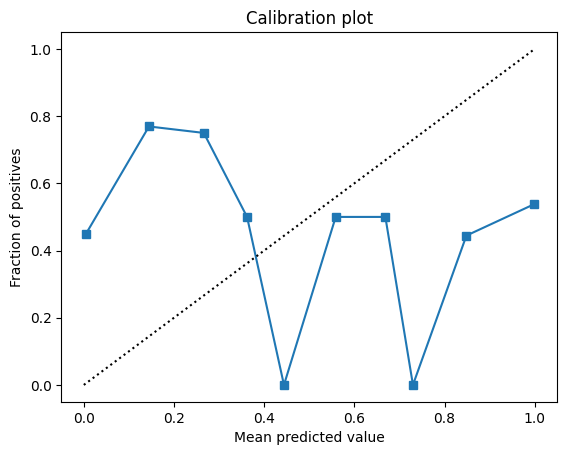

Brier Score: 0.4493245518155546


In [87]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# If your predictions are probabilities for positive class:
y_prob = [p.values[1] for p in predictions]
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "k:")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot")
plt.show()

print("Brier Score:", brier_score_loss(y_true, y_prob))


The bottom line is that this model is not good. So what can I do to fix this?

Possible Reasons:

1. Discretization Issues: The way the ECG signals have been discretized (or the chosen number of bins) might not be capturing enough discriminative information.

2. Feature Representation: Raw ECG signals might benefit from feature extraction (e.g., capturing R-wave amplitude, ST-segment changes) rather than direct discretization.

3. Model Structure: If the DBN’s transition or emission CPDs are too rigid (e.g., nearly deterministic for a stable latent variable), the model might not be sensitive enough to variations in the ECG that actually matter.

4. Data Quality/Preprocessing: Noise in the ECG or other preprocessing issues might be obscuring informative patterns.

Next Steps for Improvement:

1. Revisit Discretization: Consider testing alternative discretization schemes. You might try a different number of bins, non-uniform bins based on domain knowledge, or a lead-specific approach.

2. Feature Engineering: Instead of—or in addition to—discretizing the raw ECG, extract clinically relevant features from each lead.

3. Model Tuning: Re-examine your DBN structure. For instance, adding flexibility to the transition or emission models, or incorporating domain-specific priors, might help.

4. Baseline Comparison: Compare your results to a simple baseline (e.g., always predict the majority class, or a simple logistic regression on engineered features) to gauge the relative performance.

5. Parameter Sensitivity: Experiment with hyperparameters of your model and the inference procedure. Sometimes small changes in discretization or network structure can lead to noticeable improvements.

To address discretization, I can't do more than 4 bins because that will cause inference to consume too much memory. Maybe there is a better way to discretize the ECG data? OR am I losing out by discretizing the data in the first place?

If I don't want to discretize the data how I can I use a DBN with continuous data?

Can I use self-supervised representation learning (SSRL) to make the ECG data more meaningful? Self-supervised learning is a machine learning process where the model trains itself to learn one part of the input from another part of the input. It is also known as predictive or pretext learning. Pretend there is a part of the input you don't know and predict that.

What is ECG Delineation? 
ECG delineation is the process of pinpointing the start and end of each ECG wave (P-wave, QRS complex, and T-wave) on the ECG tracing. 
This is crucial for accurate interpretation and diagnosis of heart conditions. 
It involves identifying key points on the ECG waveform, such as the beginning and end of the P-wave, QRS complex, and T-wave. 

So, by looking at the 12-lead ECG data you should be able to identify when different waves (and other measures) start and stop.

After doing a lot of investigation online, it seems that my best bet is to try and use someone else's model to do delineation, and then to try and build a new DBN based on the features from delineation.

Tbh this semms like a problem better suited for deep learning.

NEXT STEP, TRY torch_ecg FOR WAVE DELINEATION WITH THE UNET MODEL.

Note that maybe this problem is best solved with some sort of conv net architecture.

Yes, they can be considered a time series. Typically, when you extract features like the P-wave, QRS complex, and T-wave from an ECG, you do so on a per-beat basis (or over a sliding window), which produces a sequence of feature measurements over time. For example, if you extract the duration and amplitude of the QRS complex for each beat, you'll end up with a time series where each point corresponds to the QRS characteristics of a particular beat.

How you treat these features depends on your analysis:

Per-Beat Extraction:
If you extract features for every beat, you'll have a time series of feature vectors—one vector per beat.

Window-Based Extraction:
Alternatively, you could segment your ECG into fixed-length windows and compute summary features for each window, which again gives you a time series of features.

In either case, these features are sequential data, and you can analyze their evolution over time or use them as inputs to a time-series model, such as a DBN, HMM, or even recurrent neural networks.

Would you like more details on how to perform such feature extraction or how to model these extracted features as a time series?

So there appears to be one big issue for torch_ecg: Torch-ECG provides the architecture for the U-Net model but doesn't include pre-trained weights. This means that while you can instantiate the U-Net model, it won't have any learned knowledge until it's trained on a dataset, which I don't have.

A possible alternative is neurokit. NeuroKit employs traditional signal processing techniques for ECG delineation. Specifically, it utilizes methods like the discrete wavelet transform (DWT) to analyze the ECG signal and identify the characteristic points of the cardiac cycle, such as P-peaks, QRS complexes, and T-peaks. These methods are grounded in established physiological knowledge and mathematical transformations

The performance of both approaches can vary depending on the quality of the ECG signal, the presence of noise, and the specific characteristics of the dataset. Some studies suggest that while traditional methods like those in NeuroKit provide reliable temporal accuracy, neural network approaches may offer improved sensitivity in detecting certain ECG components. 

IT WILL BE VERY HARD TO FIND A PRETRAINED NEURALNET FOR ECG WAVE DELINEATION. I DONT HAVE WAVE DELINEATION TRAINING LABELS IN MY CURRENT DATA, AND TRAINING A NEW MODEL DOESN'T SEEM LIKE A GOOD USE OF TIME. I WILL TRY NEUROKIT WHICH USES SIGNAL PROCESSING.

With the signal processing approach I get something like this for each sample:

sample_idx,lead,heart_rate,r_peaks,pr_interval,qrs_complex,qt_interval,rr_interval,st_segment.  
0,II,72.412,[ 153  490  824 1154 1485 1819 2154 2485 2805],83.000,134.250,314.250,663.000,71.778

While these are features, they are not "time series features" necessarily, so how do they fit into the current data?

To make it a time series, I could do something like pr_interval is a state and it takes on value 1 when it is the start of an interval, and so on for the other complex/intervals/segments. But that would have to line up with one second timesteps. Which it does not.

I.e. We have data at 0, 400, 800, etc. but pr_interval is every 83. That is not a multiple of 400.

Yifan said I could try to get a good baseline result and then proceed.

Here is the idea for how I can take the extracted features and turn it into a dataset suitable for DBN:

Each timestep = beat, anchored on R-peaks

Each observation = binary feature vector indicating if certain wave events (like P/QRS/T onsets or offsets) fall within a window around that beat

The target latent state = presence/absence of a condition (if labeled)